# IN6227 Data Mining – Assignment 2

## IN6227-2023-Assignment-2

## LIU XINWEI (G2103290E)

## Imports

In [1]:
%matplotlib inline

C:\Users\cryse\Anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\cryse\Anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\cryse\Anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from apyori import apriori
import itertools
import copy
import math
import datetime

## Load Datasets 

In [3]:
# df = pd.read_csv('data/April2021_CITIBike_BikeSharing-NewYork.csv')

In [4]:
# df.head()

In [5]:
# df.info()

## Data Preprocessing

### Annotate Data According to Time Segments

In [6]:
def gen_time_segment(dt):
    if dt.minute < 30:
        minute = "%02d" % 0
    else:
        minute = "%02d" % 30
    return "{}-{}-{} {}:{}".format(dt.year, dt.month, dt.day, dt.hour, minute)

def process_trip_data(csv_data):
    df = pd.read_csv(csv_data)
    df.dropna(axis=1, how='any')

    df['starttime'] = pd.to_datetime(df['starttime'], format='%Y-%m-%d %H:%M:%S')
    df['stoptime'] = pd.to_datetime(df['stoptime'], format='%Y-%m-%d %H:%M:%S')
    df['start_seg'] = [gen_time_segment(dt) for dt in df['starttime']]
    df['stop_seg'] = [gen_time_segment(dt) for dt in df['stoptime']]
    return df

### Group and Count Data with Time Segments

In [7]:
def get_station_id_and_inflow_and_outflow(data_frame_trip_data):
    t1 = data_frame_trip_data[['start station id', 'start station name', 'start station latitude', 'start station longitude']] \
            .drop_duplicates().rename(columns = {'start station id':'station id', \
                                                    'start station name':'station name', \
                                                    'start station latitude':'station latitude', 
                                                    'start station longitude': 'station longitude'})
    t2 = data_frame_trip_data[['end station id', 'end station name', 'end station latitude', 'end station longitude']] \
            .drop_duplicates().rename(columns = {'end station id':'station id', \
                                            'end station name':'station name', \
                                            'end station latitude':'station latitude', \
                                            'end station longitude': 'station longitude'})
    df_loc = pd.concat([t1, t2]).drop_duplicates()
    inflow = data_frame_trip_data[['end station id', 'stop_seg']] \
            .groupby(['end station id', 'stop_seg']) \
            .size().reset_index(name='counts') \
            .rename(columns={'end station id':'station id','stop_seg':'time', 'counts':'in_flow_count'})


    outflow = data_frame_trip_data[['start station id', 'start_seg']] \
            .groupby(['start station id', 'start_seg']) \
            .size().reset_index(name='counts') \
            .rename(columns={'start station id':'station id','start_seg':'time', 'counts':'out_flow_count'})

    station_id_list = list(df_loc['station id'])
    return station_id_list, inflow, outflow

### Merge In-flow and Out-flow for Each Station within Time Segments

In [8]:
def extract_in_out_flows(start_date, end_date, station_id_list, inflow, outflow ):
    # Create combinations of time series and station ids
    time_seg_list = list(pd.date_range(start_date, end_date, freq="30min"))
    template = pd.DataFrame(list(itertools.product(station_id_list, time_seg_list)), \
                            columns=["station id", "time"])

    # Merge in/out flow information & Add zeros to missing data according to every time segment
    dat = pd.merge(inflow, outflow, on=['station id', 'time'], how='outer')
    dat['time'] = pd.to_datetime(dat['time'], format='%Y-%m-%d %H:%M')
    dat = dat.merge(template, on=["station id", "time"], how="right").fillna(0)
    return dat

## Define Transactions

### A transaction consists of:
- time of a day
- station ID
- flow count of that station (sum up in-flow count and out-flow count)

### Discretization Method on Time Segments

- 00:00 ~ 06:00: Night
- 06:00 ~ 11:00: Morning
- 11:00 ~ 13:00: Noon
- 13:00 ~ 16:00: Afternoon
- 16:00 ~ 22:00: Evening
- 22:00 ~ 24:00: Night

In [9]:
def get_station_specific_data(df_flow, station_id):
    df_flow['time'] = pd.to_datetime(df_flow['time'], format='%Y-%m-%d %H:%M:%S')
    dat = df_flow[df_flow['station id'] == station_id][['time', 'in_flow_count', 'out_flow_count']]
    dat['flow_count'] = dat['in_flow_count'] + dat['out_flow_count']
    dat['time'] = ["{:02d}:{:02d}".format(dt.hour, dt.minute) for dt in dat['time']]
    dat = dat[['time', 'flow_count']]
    dat['time'] = pd.to_datetime(dat['time'], format='%H:%M')
    dat_copy = copy.deepcopy(dat)
    mapping = ["Night"]*6 + ["Morning"]*5 + ["Noon"]*2 + ["Afternoon"]*3 + ["Evening"]*6 + ["Night"]*2
    dat_copy['time'] = [mapping[math.floor(dt.hour)] for dt in dat_copy['time']]
    if len(dat_copy) == 0:
        return dat_copy
    flow_count_names = pd.qcut(dat_copy['flow_count'].unique(), q = 3, \
                                    labels = ["low", "medium", "high"]).astype(str)
    flow_count_numbers = dat_copy['flow_count'].unique()
    flow_map = dict(zip(flow_count_numbers, flow_count_names))
    dat_copy['flow_count'] = dat_copy['flow_count'].apply(lambda k: flow_map[k])
    return dat_copy

In [10]:
def get_data_frames_start_end_dates_and_station_ids(start_date, end_dates, station_ids):
    data_frames = []
    for end_date, station_id in zip(end_dates, station_ids):
      df_flow = extract_in_out_flows(start_date, end_date, station_id_list=station_id_list, inflow=inflow, outflow=outflow)
      data_frame = get_station_specific_data(df_flow, station_id)
      data_frames.append(data_frame)
    return data_frames

In [11]:
csv_file = 'data/April2021_CITIBike_BikeSharing-NewYork.csv'
df_processed = process_trip_data(csv_data=csv_file)
station_id_list, inflow, outflow = get_station_id_and_inflow_and_outflow(data_frame_trip_data=df_processed)
start_date = "2021-04-01 00:00:00"
end_dates = ["2021-04-06 23:30:00", "2021-04-12 23:30:00", "2021-04-18 23:30:00", "2021-04-24 23:30:00", "2021-04-30 23:30:00"]
station_ids = [3225, 3186, 3639, 3792, 3205, 3199, 3269, 3206, 3211, 3185]
data_frames = get_data_frames_start_end_dates_and_station_ids(start_date, end_dates, station_ids)

# Association Rule Mining

In [12]:
def get_counts_and_perf_logs(data_frames, fn):
    cols = set()
    perf_logs = []
    for _ in range(0, 80):
      time_log = []
      for data_frame in data_frames:
        cols.add(len(data_frame.index))
        start_time = datetime.datetime.now()
        fp = fn(data_frame.values.tolist(), 0.03, 0.6)
        end_time = datetime.datetime.now()
        time_taken = end_time - start_time
        time_log.append(time_taken.microseconds)
      perf_logs.append(time_log)
    perf_logs = np.array(perf_logs)
    cols = sorted(list(cols))
    return cols, perf_logs

def draw_box_plot(cols, perf_logs):
    df = pd.DataFrame(perf_logs,columns=cols)
    boxplot = df.boxplot(column=cols)
    boxplot.set_xlabel('Counts')
    boxplot.set_ylabel('Time (in microseconds)')
    return boxplot

## Apriori Algorithm

In [13]:
def apriori_find_association_rules(dataset, minsup, minconf):
    records = list(apriori(dataset, min_support=minsup, min_confidence=minconf))
    return records

def apriori_show_mining_results(records):
    ap = []
    for record in records:
        converted_record = record._replace(ordered_statistics=[x._asdict() for x in record.ordered_statistics])
        ap.append(converted_record._asdict())
    
    print("Frequent Itemsets:\n------------------")
    for ptn in ap:
       print('({})  support = {}'.format(", ".join(ptn["items"]), round(ptn["support"], 3)))
    print()
    
    print("Rules:\n------")
    for ptn in ap:
        for rule in ptn["ordered_statistics"]:
            head = rule["items_base"]
            tail = rule["items_add"]
            if len(head) == 0 or len(tail) == 0:
                continue
            confidence = rule["confidence"]
            print('({}) ==> ({})  confidence = {}'.format(', '.join(head), ', '.join(tail), round(confidence, 3)))
    print()

### Box Plots

<AxesSubplot:xlabel='Counts', ylabel='Time (in microseconds)'>

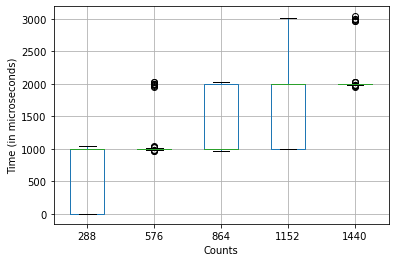

In [14]:
apriori_cols, apriori_perf_logs = get_counts_and_perf_logs(data_frames, apriori_find_association_rules)
draw_box_plot(apriori_cols, apriori_perf_logs)

## Brute Force Approach

In [15]:
def brute_force_association_mining(dataset, minsup, minconf):
	dataset = np.array(dataset)
	df = pd.DataFrame(dataset)
	itemset = set()
	for col in df:
		itemset.update(df[col].unique())
	items = sorted(list(itemset))
	ic = len(items)
	tc = len(df.index)
	trans=[]
	for index, row in df.iterrows():
		tran= [0] * len(itemset)
		rowset = set(row)
		commons = list(itemset.intersection(rowset))
		for com in commons:
			com_index = items.index(com)
			tran[com_index] = 1
			trans.append(tran)

	trans1=[]
	for x in range(tc):
		tran1=[]
		for y in range(ic):
			if(trans[x][y]==1):
				tran1.append(y)
		trans1.append(set(tran1))

	L=[]
	for l in range(1,ic+1):
		for subset in itertools.combinations(range(ic),l):
			L.append(set(subset))

	LC=[]
	for l in L:
		lc=0
		for t in trans1:
			if(l.issubset(t)):
				lc+=1
		LC.append(lc)
	C=[]
	CC=[]
	for x in range(len(LC)):
		if(LC[x]>=minsup):
			C.append(list(L[x]))
			CC.append(LC[x])
	LHS = [] 
	RHS = []
	conf = []
	for item in range(len(C)):
		for citem in range(len(C)):
			index=0
			te=list(set(C[item]).union(set(C[citem])))
			if((te in C )and(te != C[item])and(te!=C[citem])and(not(set(C[item])&set(C[citem])))): 
				for x in range(len(C)):
					if(te==C[x]):
						index=x
				temp = float(CC[index])/float(CC[item])
				if(temp>=minconf):
					LHS.append(C[item])
					RHS.append(C[citem])
					conf.append(temp)
	return (C, CC, LHS, RHS, conf)

### Box Plots

<AxesSubplot:xlabel='Counts', ylabel='Time (in microseconds)'>

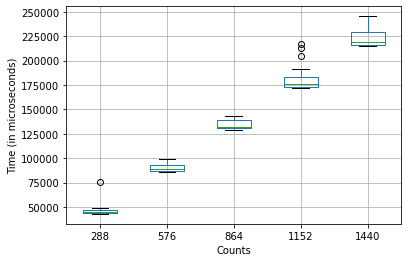

In [16]:
brute_cols, brute_perf_logs = get_counts_and_perf_logs(data_frames, brute_force_association_mining)
draw_box_plot(brute_cols, brute_perf_logs)

## Matlib Plots

In [17]:
def draw_plots(col_sets, perf_log_sets, color_sets, label_sets):
  plot_df_sets = []
  y_max = 0
  for cols, logs, color, label in zip(col_sets, perf_log_sets, color_sets, label_sets):
    df = pd.DataFrame(logs,columns=cols)
    data = np.array(logs)
    y = data.mean(axis=0)
    y_max = max(max(y), y_max)
    x = cols
    avgs = []
    std_devs = []
    std_err = []
    for col in cols: 
      std_err.append(df[col].sem())
      avgs.append(df[col].mean()) 
      std_devs.append(df[col].std())
    error = np.array(std_err)
    std_dev = np.array(std_devs)
    plt.plot(x, y, 'k-', label=label)
    plt.fill_between(x, y-std_dev/2, y+std_dev/2, color=color)
    plt.fill_between(x, y-error/2, y+error/2, color='red')    
    data = {'count': cols, 'avg. time': avgs, 'std. deviation': std_devs, 'std. error': std_err}
    plot_df = pd.DataFrame(data)
    plot_df_sets.append(plot_df)
  plt.ylim((0, y_max + 500))
  plt.xlabel("Count")
  plt.ylabel("Time (microseconds)")
  plt.legend()
  plt.show()
  return plot_df_sets

# Plot of measured time

## Scale down Brute Force results

In [18]:
brute_perf_logs = np.array(brute_perf_logs)
brute_perf_scaled_logs = brute_perf_logs/20

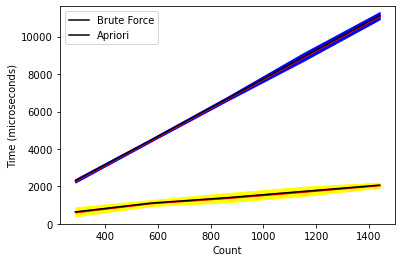

[   count     avg. time  std. deviation  std. error
 0    288   2297.103125      185.102675   20.695108
 1    576   4481.121250      147.056980   16.441470
 2    864   6688.338125      205.062177   22.926648
 3   1152   8918.045000      420.738778   47.040025
 4   1440  11118.972500      386.670602   43.231088,
    count  avg. time  std. deviation  std. error
 0    288   635.8875      482.618727   53.958414
 1    576  1110.5250      316.972305   35.438581
 2    864  1397.1875      491.663209   54.969618
 3   1152  1732.0875      493.387726   55.162425
 4   1440  2068.7000      264.900478   29.616774]

In [19]:
draw_plots([brute_cols, apriori_cols], [brute_perf_scaled_logs, apriori_perf_logs], ['blue', 'yellow'], ['Brute Force', 'Apriori'] )